## Forecasting specific drug common name

In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import datetime
# import xlrd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
warnings.filterwarnings('ignore')

In [2]:
# Load updated shorage database
df = pd.read_csv("Shortage data/shortage_final.csv")

# converting headers in lowercase
df.columns = df.columns.str.lower()

# replacing spaces for "_" in headers
df.columns = df.columns.str.replace(' ', '_')

# converting drugsname in lowercase
df['common_or_proper_name'] = df['common_or_proper_name'].str.lower()

# Removing NaN actual_start_date and actual_end_date, considering as an incomplete record
df=df.dropna(subset=['actual_start_date','actual_end_date'] )

# Removing Actuals before 2017
df = df.loc[(df['actual_start_date'] >= '2017-01-01')]
# Removing outliers before 2017 for End_date
df = df.loc[(df['actual_end_date'] >= '2017-01-01')]

# Removing duplicates ID Reports
df=df.drop_duplicates("report_id", keep=False)

# Removing Avoided shortages (outliers for our analysis)
df = df[df['shortage_status']!="Avoided shortage"]

# converting into datatime critical field
df['actual_start_date'] = df['actual_start_date'].astype('datetime64[D]')
df['actual_end_date'] = df['actual_end_date'].astype('datetime64[D]')

# Fill null DIN with zero, convering into integer
df['drug_identification_number'] = df['drug_identification_number'].fillna(0)
df['drug_identification_number'] = df['drug_identification_number'].astype('int')


# calculating # of days of shortages
df['Days']= df['actual_end_date']-df['actual_start_date']

# Create clear field number of days as integer
df['Days2'] = df['Days'].dt.days
df['Days2']=df['Days2'].astype('int')

# Removing negative days
df= df[(df['Days2']>=0)]
df.Days2.min()

df.shape

(13476, 24)

In [3]:
print ("Unique values:  \n",df.nunique())

Unique values:  
 report_id                     13476
drug_identification_number     5475
report_type                       1
brand_name                     3438
company_name                    196
common_or_proper_name          4165
ingredients                    1174
strength(s)                     871
packaging_size                 2424
route_of_administration         177
shortage_status                   2
dosage_form(s)                  121
atc_code                        463
atc_description                 201
anticipated_start_date         1257
actual_start_date              1706
estimated_end_date             1602
actual_end_date                1677
reason                            7
date_created                   1518
date_updated                   1802
tier_3                            2
Days                            817
Days2                           817
dtype: int64


Show proportional Resolved/Actual cases, and outliers

<AxesSubplot:xlabel='shortage_status', ylabel='Days2'>

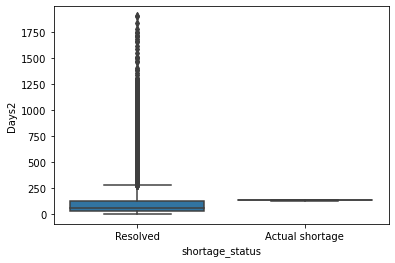

In [4]:
sns.boxplot(data = df,
                x =df['shortage_status'],
                y = df['Days2'])

Getting specific drug for analysis

In [5]:
df = df[df.common_or_proper_name=='acetaminophen']
df.head()

,report_id,drug_identification_number,report_type,brand_name,company_name,common_or_proper_name,ingredients,strength(s),packaging_size,route_of_administration,...,anticipated_start_date,actual_start_date,estimated_end_date,actual_end_date,reason,date_created,date_updated,tier_3,Days,Days2
66,110331,2362368,Shortage,ACETAMINOPHEN CAPLETS 500 MG,APOTEX INC,acetaminophen,ACETAMINOPHEN,500MG,100 BTL,ORAL,...,NaN,2020-03-30,2020-04-13,2020-03-30,Disruption of the manufacture of the drug.,2020-04-01,2020-04-01,No,0 days,0
70,181973,2362422,Shortage,ACETAMINOPHEN TABLETS USP 325 MG,APOTEX INC,acetaminophen,ACETAMINOPHEN,325MG,100 BTL,ORAL\r\nORAL,...,NaN,2023-01-17,2023-02-24,2023-02-17,Disruption of the manufacture of the drug.,2023-01-20,2023-02-23,No,31 days,31
72,110339,2362244,Shortage,ACETAMINOPHEN TABLETS USP 500 MG,APOTEX INC,acetaminophen,ACETAMINOPHEN,500MG,100 BTL,ORAL,...,NaN,2020-03-30,2020-06-05,2020-05-22,Disruption of the manufacture of the drug.,2020-04-01,2020-05-25,No,53 days,53
502,160601,544981,Shortage,APO-ACETAMINOPHEN,APOTEX INC,acetaminophen,ACETAMINOPHEN,325MG,100 U/D,ORAL\r\nORAL,...,NaN,2022-05-11,2022-07-08,2022-07-07,Disruption of the manufacture of the drug.,2022-05-13,2022-07-11,No,57 days,57
503,170106,544981,Shortage,APO-ACETAMINOPHEN,APOTEX INC,acetaminophen,ACETAMINOPHEN,325MG,1000 BTL,ORAL\r\nORAL,...,NaN,2022-09-19,2022-11-18,2022-10-20,Disruption of the manufacture of the drug.,2022-09-23,2022-10-21,No,31 days,31


Histogram of # of days of shortage

array([[<AxesSubplot:title={'center':'Days2'}>]], dtype=object)

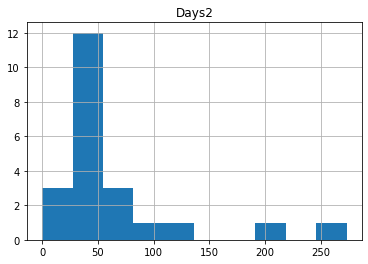

In [6]:
df.hist(column='Days2')

Distribution over the period

<AxesSubplot:xlabel='actual_start_date', ylabel='Days2'>

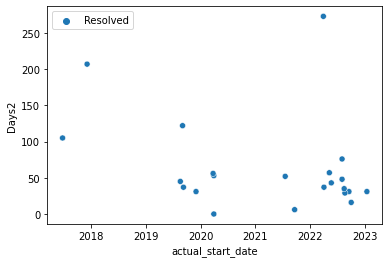

In [7]:
# Create a scatter plot of time and # of Days
sns.scatterplot(data = df, x =df['actual_start_date'],
                               y = df['Days2'],
                               hue=df.shortage_status.tolist())

In [8]:
df.Days2.max()

273

<AxesSubplot:title={'center':'Days Distribution'}, ylabel='# of Days'>

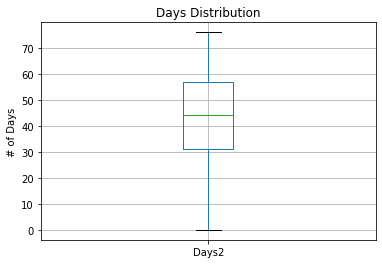

In [9]:
# Create a box plot to identify outliers

Boxplot, bp=plt.subplots()
# bp.set_xlabel('Days')
bp.set_ylabel('# of Days')
bp.set_title('Days Distribution')
bp.grid()
df.boxplot(column="Days2", showfliers=False)

In [10]:
# Get Date into months and years
df['Date'] = df.index
df['Year'] = df['actual_start_date'].dt.year
df['Month'] = df['actual_start_date'].dt.month

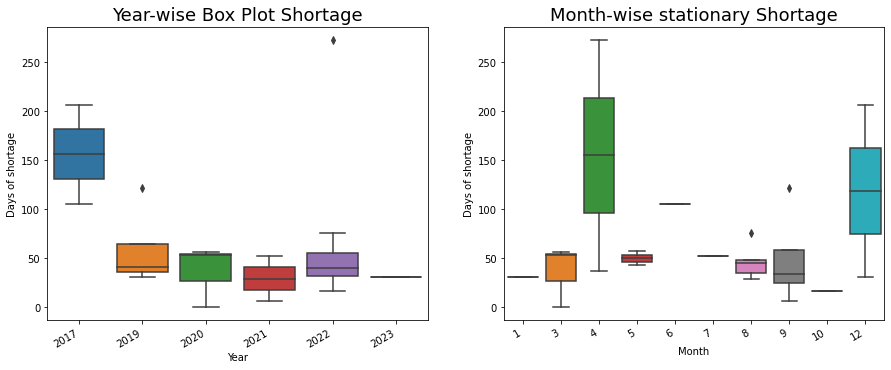

In [11]:
# Splitting the plot into (1,2) subplots
# and initializing them using fig and ax
# variables
fig, ax = plt.subplots(nrows=1, ncols=2,
					figsize=(15, 6))

# Using Seaborn Library for Box Plot
sns.boxplot(df['Year'],
			df["Days2"], ax=ax[0])

# Defining the title and axes names
ax[0].set_title('Year-wise Box Plot Shortage',
				fontsize=18, loc='center')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Days of shortage')

# Using Seaborn Library for Box Plot
sns.boxplot(df['Month'],
			df["Days2"], ax=ax[1])

# Defining the title and axes names
ax[1].set_title('Month-wise stationary Shortage',
				fontsize=18, loc='center')
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Days of shortage')

# rotate the ticks and right align them
fig.autofmt_xdate()


In [12]:
col_list = ['actual_start_date', 'Days2']
df = df[col_list]

In [13]:
df.columns = ['ds', 'y']

In [14]:
df.shape

(22, 2)

### 1 year Forecasting using Prophet

In [15]:
m = Prophet(changepoint_prior_scale=10, 
            changepoint_range= 1, 
            seasonality_mode = 'multiplicative', 
            seasonality_prior_scale=0.3, 
            weekly_seasonality=20, 
            yearly_seasonality=5, 
            daily_seasonality=25) 
m.fit(df)


15:32:43 - cmdstanpy - INFO - Chain [1] start processing
15:32:49 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
future = m.make_future_dataframe(periods=365, freq='D')
future.tail()

,ds
380,2024-01-13
381,2024-01-14
382,2024-01-15
383,2024-01-16
384,2024-01-17


In [17]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
380,2024-01-13,34.230744,-170.685915,264.175350
381,2024-01-14,33.556814,-167.043460,255.894748
382,2024-01-15,6.800738,-37.762634,55.583301
383,2024-01-16,17.344286,-87.976652,141.137761
384,2024-01-17,19.282131,-99.004344,153.649691


Text(51.5, 0.5, 'Days of Shortage')

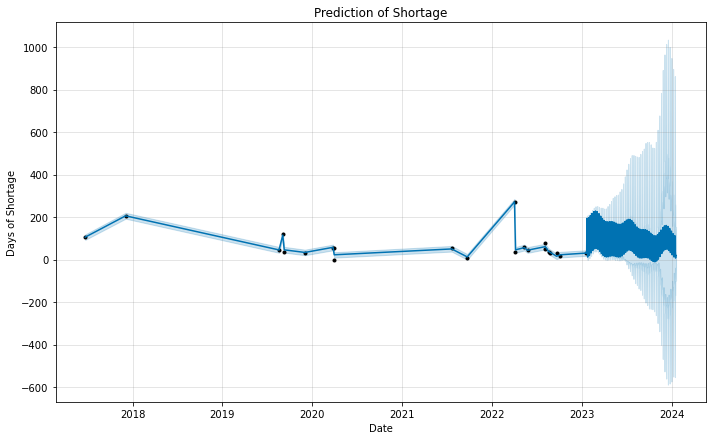

In [18]:
fig1 = m.plot(forecast)
plt.title("Prediction of Shortage")
plt.xlabel("Date")
plt.ylabel("Days of Shortage")

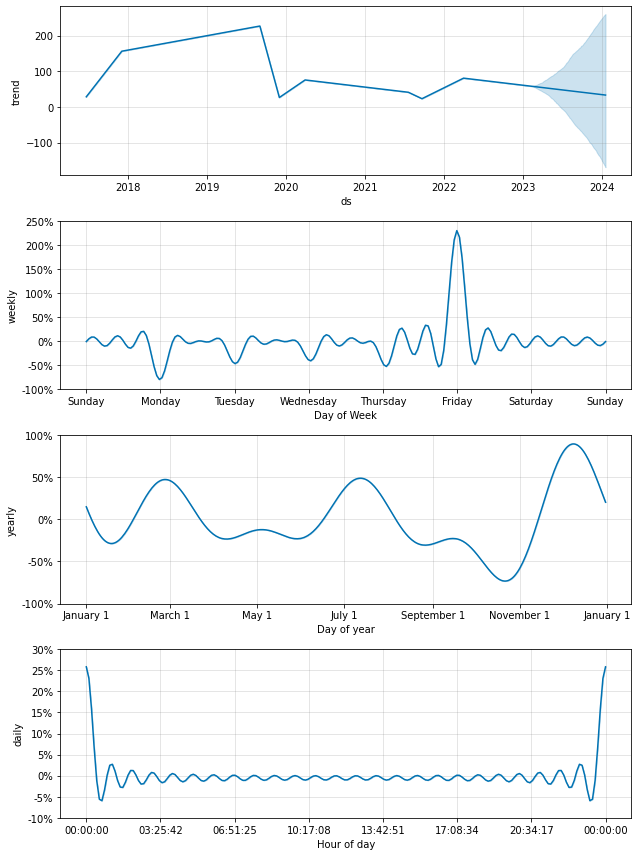

In [19]:
fig2 = m.plot_components(forecast)

(0.0, 298.30087764036017)

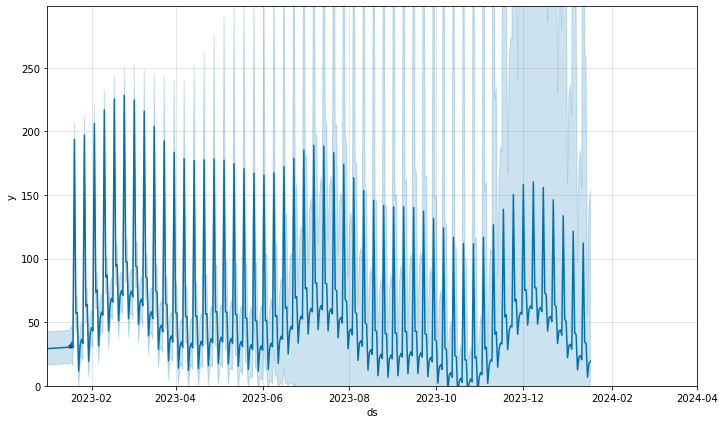

In [20]:
fig = m.plot(forecast)
ax = fig.gca()
# setting x limit. date range to plot
ax.set_xlim(pd.to_datetime(['2023-01-01', '2024-04-01'])) 
ax.set_ylim([0, forecast.yhat.max()*1.1]) 

Zoom in into predicted values

In [21]:
from prophet.plot import plot_plotly, plot_components_plotly
plot_plotly(m, forecast)